### LSTM을 이용한 로이터 뉴스 데이터셋 분류하기
#### 긴 텍스트를 읽고 데이터가 어떤 의미를 지니는지를 카테고리별로 분류하는 작업을 위해 학습을 해보자.
1. 로이터 뉴스 데이터 불러오기
2. 데이터 형태및 자료 파악하기
3. 데이터 전처리
4. 모델 설계
5. 학습 및 예측

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import reuters

In [3]:
reuter = reuters.load_data()

2113536/2110848 [==============================] - 0s 0us/step


In [5]:
(x_train, y_train),(x_test, y_test) = reuters.load_data(num_words=1000, test_split = 0.2)

- 원래 텍스트를 이용해서 딥러닝을 진행하고자 할 때에는 tokenizer이라는 과정을 거쳐서 각 단어의 빈도수별로 숫자로 번호를 매겨서 단어를 저장하고자 한다.
- 그러나 keras에서 데이터를 불러올 때에는 그 작업이 이미 되어있음을 알 수 있다. 빈도수가 높은 단어의 번호가 더 낮은데, 위의 경우에 load_data에 넣는 num_word의 의미는 빈도수가 1000번째로 많은 단어만 입력으로 받겠다는 의미이고, test_split을 설정해 주는 방법으로 전체 데이터의 20%를 테스트 데이터로서 저장을 하게 된다.

In [7]:
x_train.shape,y_train.shape,x_test.shape, y_test.shape

((8982,), (8982,), (2246,), (2246,))

In [10]:
y_train[0]

3

- 우리가 예측해야 하는 target 인 y값들에는 x값에 있는 문장의 카테고리가 숫자의 형태로 지정이 되어있다.

In [9]:
for i in range(10):
  print(len(x_train[i]))

87
56
139
224
101
116
100
100
82
106


- 여기서 데이터를 처리해야 하는 부분이 생긴다. 
- 각각의 데이터에는 위에서 지정해준 대로 1000번째 빈도수까지의 데이터가 저장이 되어 있기 때문에 각각의 문장마다 데이터로서 load 된 단어의 개수가 다를 수 밖에 없다. 
- 이를 해결하기 위해서는 keras.preprocessing을 이용해서 기사의 단어의 수를 맞춰 줄 수가 있다.
- 정해준 길이보다 길면 그냥 slicing을 하고, 짧으면 빈 자리를 0으로 채워준다.

- keras.utils의 모듈인 np_utils.to_categorical 을 이용해서 one-hot encoding을 진행한다.
- word2vec으로 진행하는 embedding과의 차이는 embedding은 단어 벡터간의 거리를 유사도로서 고려해서 벡터로 환산해준단 점이다.

In [24]:
from keras.preprocessing import sequence
from keras.utils import np_utils
x_train = sequence.pad_sequences(x_train, maxlen = 100)
x_test = sequence.pad_sequences(x_test, maxlen = 100)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [26]:
x_train.shape

(8982, 100)

In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(1000,100))
#Embedding Layer에는 데이터가 (불러온 단어의 총 개수, 기사당 단어 수)의 형태로 입력이 되어야 한다.
#LSTM Layer(RNN에서 기억값에 대한 가중치를 변화시킨다)
model.add(tf.keras.layers.LSTM(100, activation = 'tanh'))
#이 문제는 '분류'문제이기 때문에 총 46개의 class들중 어느것에 더 가까울지의 '비율'을 구해주는 것에 목적을 둔다.
model.add(tf.keras.layers.Dense(46, activation = 'softmax'))

In [33]:
def last_time_step_mse(true, predict):
  return tf.keras.metrics.mean_squared_error(true[:,-1], predict[:,-1])

In [36]:
model.compile(loss = 'mse', optimizer = tf.keras.optimizers.Adam(lr = 0.01), metrics = [last_time_step_mse, 'accuracy'])

In [38]:
history = model.fit(x_train, y_train, validation_split = 0.2, epochs = 30)

Epoch 1/30
225/225 [==============================] - 22s 97ms/step - loss: 0.0130 - last_time_step_mse: 0.0020 - accuracy: 0.5134 - val_loss: 0.0114 - val_last_time_step_mse: 0.0022 - val_accuracy: 0.5693
Epoch 2/30
225/225 [==============================] - 21s 95ms/step - loss: 0.0107 - last_time_step_mse: 0.0019 - accuracy: 0.6079 - val_loss: 0.0101 - val_last_time_step_mse: 0.0022 - val_accuracy: 0.6583
Epoch 3/30
225/225 [==============================] - 21s 95ms/step - loss: 0.0094 - last_time_step_mse: 0.0019 - accuracy: 0.6718 - val_loss: 0.0098 - val_last_time_step_mse: 0.0022 - val_accuracy: 0.6678
Epoch 4/30
225/225 [==============================] - 21s 95ms/step - loss: 0.0089 - last_time_step_mse: 0.0019 - accuracy: 0.6913 - val_loss: 0.0093 - val_last_time_step_mse: 0.0022 - val_accuracy: 0.6728
Epoch 5/30
225/225 [==============================] - 22s 96ms/step - loss: 0.0086 - last_time_step_mse: 0.0019 - accuracy: 0.7042 - val_loss: 0.0096 - val_last_time_step_mse: 

In [39]:
model.evaluate(x_test, y_test)

71/71 [==============================] - 2s 27ms/step - loss: 0.0096 - last_time_step_mse: 4.5862e-04 - accuracy: 0.6839


[0.009641153737902641, 0.0004586172290146351, 0.683882474899292]

Text(0, 0.5, 'loss')

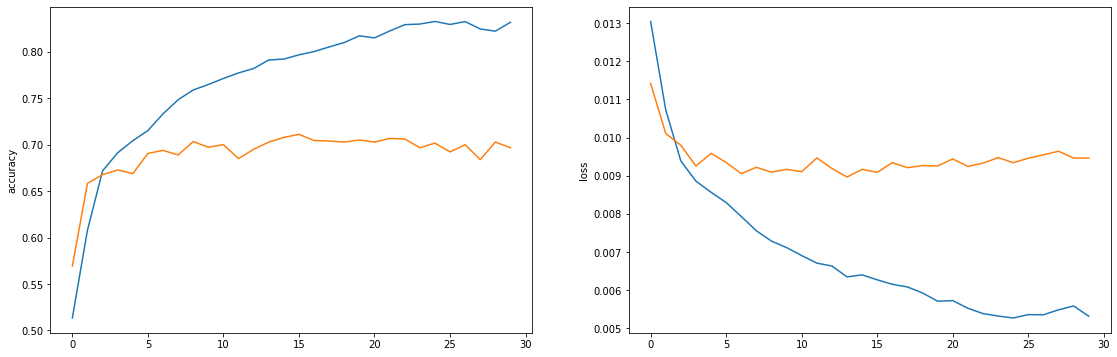

In [77]:
fig, axes = plt.subplots(1,2,figsize = (19,6))
axes[0].plot(df[['accuracy','val_accuracy']])
axes[0].set_ylabel('accuracy')
axes[1].plot(df[['loss', 'val_loss']])
axes[1].set_ylabel('loss')

In [89]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [102]:
pred = model.predict(x_test[0])
print(len(pred[0]))
file = []
for i in range(len(pred)):
  file.append(sum(pred[i]))
file.index(max(file))

46


54

In [111]:
x,y = x_test, y_test
pred = model.predict(x)
right, wrong = 0,0
for i in range(0,len(pred),10):
  index = list(pred[i]).index(max(pred[i]))
  if list(y[i]).index(1.) == index:right += 1
  else:wrong += 1
  print('real:{} predict:{}'.format(list(y[i]).index(1.), index))
print(right, wrong)

real:3 predict:3
real:5 predict:1
real:8 predict:18
real:3 predict:3
real:15 predict:13
real:20 predict:20
real:4 predict:3
real:21 predict:13
real:3 predict:3
real:3 predict:3
real:8 predict:19
real:3 predict:19
real:3 predict:3
real:19 predict:8
real:3 predict:3
real:11 predict:4
real:3 predict:3
real:3 predict:3
real:19 predict:3
real:19 predict:21
real:16 predict:25
real:3 predict:3
real:3 predict:3
real:4 predict:4
real:19 predict:8
real:4 predict:4
real:19 predict:12
real:4 predict:4
real:3 predict:20
real:3 predict:3
real:3 predict:3
real:16 predict:3
real:35 predict:34
real:19 predict:19
real:19 predict:19
real:4 predict:4
real:4 predict:4
real:11 predict:11
real:10 predict:1
real:3 predict:3
real:4 predict:4
real:3 predict:3
real:3 predict:3
real:1 predict:5
real:32 predict:28
real:19 predict:19
real:4 predict:3
real:19 predict:19
real:3 predict:3
real:3 predict:3
real:3 predict:3
real:3 predict:3
real:3 predict:3
real:4 predict:17
real:2 predict:2
real:4 predict:4
real:3 pred